In [1]:
# Fits table reading here : https://docs.astropy.org/en/stable/io/fits/
# import numpy as np
# import matplotlib.pyplot as plt

import sys
import os
import numpy as np
import astropy.units as u
from pathlib import Path

import matplotlib.pyplot as plt
sys.path.append('../')
import ana_config as cf
import irf 

In [44]:
from astropy.coordinates import Angle
import numpy as np
offset = Angle("0 deg")

# On axis IRF

In [45]:
from cta_irf_onaxis import CTAPerf_onaxis
irf_file = "../../input/irf/Reco1/North/CTA-Performance-North-20deg-average-100s_20181203.fits.gz"

perfi = CTAPerf_onaxis.read(irf_file,offset=offset)     

## Background and rec. energies

In [46]:
bkg = perfi.bkg
bkg_onaxis = bkg.data.data

energy_reco = bkg.data.axis("energy").edges 
erec_center = 0.5*(energy_reco[1:]+energy_reco[:-1])
print("B Rate        (",len(bkg_onaxis),")\n",bkg_onaxis)
print("Rec. E bins   (",len(energy_reco),")\n",energy_reco)
print("Rec. E center (",len(erec_center),")\n",erec_center)

B Rate        ( 21 )
 [2.7635350e+00 8.0993309e+00 3.2145426e+00 8.5249168e-01 3.2612848e-01
 7.9694301e-02 2.4615809e-02 9.2572011e-03 4.0385560e-03 1.8980050e-03
 1.1004718e-03 4.4673344e-04 2.3430763e-04 7.1499526e-05 5.0710172e-05
 2.0539384e-05 5.8277083e-06 4.2439619e-06 3.0316432e-06 1.5268613e-06
 5.4053419e-07] Hz
Rec. E bins   ( 22 )
 [1.25892544e-02 1.99526232e-02 3.16227749e-02 5.01187220e-02
 7.94328228e-02 1.25892535e-01 1.99526235e-01 3.16227764e-01
 5.01187205e-01 7.94328213e-01 1.25892544e+00 1.99526227e+00
 3.16227770e+00 5.01187229e+00 7.94328213e+00 1.25892544e+01
 1.99526234e+01 3.16227760e+01 5.01187248e+01 7.94328232e+01
 1.25892540e+02 1.99526230e+02] TeV
Rec. E center ( 21 )
 [1.62709388e-02 2.57876990e-02 4.08707485e-02 6.47757724e-02
 1.02662679e-01 1.62709385e-01 2.57877000e-01 4.08707485e-01
 6.47757709e-01 1.02662683e+00 1.62709385e+00 2.57876998e+00
 4.08707500e+00 6.47757721e+00 1.02662683e+01 1.62709389e+01
 2.57876997e+01 4.08707504e+01 6.47757740e+01 

## Eff. area and true energies

In [47]:
aeff = perfi.aeff
aeff_onaxis = aeff.data.data

energy_true  = aeff.data.axis("energy").edges
etrue_center = 0.5*(energy_true[1:] + energy_true[:-1])
print("Aeff          (",len(aeff_onaxis),")\n",aeff_onaxis)
print("True E bins   (",len(energy_true),")\n",energy_true)
print("True E center (",len(etrue_center),")\n",etrue_center)


Aeff          ( 42 )
 [   9035.088   19447.438   33754.777   50191.633   69793.25    95604.445
  130009.28   172074.58   216418.88   254475.17   289815.75   323629.78
  355615.4    385411.84   420973.88   478053.53   549109.1    622370.1
  699687.56   773494.1    855892.75   933296.5   1004165.56  1080103.6
 1134542.1   1192649.    1238066.6   1259247.5   1293310.9   1329075.2
 1339356.5   1349344.9   1359689.9   1326998.2   1337704.2   1341964.4
 1303809.9   1322604.6   1349904.1   1303785.2   1277897.5   1220880.1  ] m2
True E bins   ( 43 )
 [1.25892528e-02 1.58489295e-02 1.99526240e-02 2.51188642e-02
 3.16227751e-02 3.98107134e-02 5.01187165e-02 6.30957380e-02
 7.94328245e-02 9.99999968e-02 1.25892532e-01 1.58489319e-01
 1.99526246e-01 2.51188650e-01 3.16227761e-01 3.98107170e-01
 5.01187211e-01 6.30957363e-01 7.94328211e-01 1.00000000e+00
 1.25892543e+00 1.58489324e+00 1.99526229e+00 2.51188628e+00
 3.16227771e+00 3.98107159e+00 5.01187257e+00 6.30957346e+00
 7.94328295e+00 1.00000

# Full enclosure
Copied from https://docs.gammapy.org/0.15/notebooks/cta_sensitivity.html#Introduction in Gpy 0.15
Initially the energy ranges are pre-defined
```python
energy_reco = np.logspace(-2, 1.5, 20) * u.TeV
energy_true = np.logspace(-2, 2, 100) * u.TeV
```

Here we use the energy bins from the IRF themselves

In [48]:
from gammapy.irf import load_cta_irfs

# Pass bins to functions, not centers
irfs = load_cta_irfs("../../input/irf/FullEnclosureOfficial/North/North_z20_average_100s/irf_file.fits")

arf = irfs["aeff"].to_effective_area_table(offset, energy=energy_true)
rmf = irfs["edisp"].to_energy_dispersion(
    offset, e_true=energy_true, e_reco=energy_reco
)
psf = irfs["psf"].to_energy_dependent_table_psf(theta=offset)

In [49]:
containment = 0.68
energy = np.sqrt(energy_reco[1:] * energy_reco[:-1])
on_radii = psf.containment_radius(energy=energy, fraction=containment)
solid_angles = 2 * np.pi * (1 - np.cos(on_radii)) * u.sr
print(on_radii)

[0d00m00s 0d21m06.9863s 0d16m57.5372s 0d12m39.115s 0d10m15.5472s
 0d08m18.8983s 0d07m01.7306s 0d06m09.6872s 0d05m32.0007s 0d04m57.9033s
 0d04m36.3681s 0d04m16.6275s 0d03m51.5032s 0d03m42.5302s 0d03m31.7626s
 0d03m24.5842s 0d03m31.7626s 0d03m37.1464s 0d03m49.7086s 0d03m15.6112s
 0d03m53.2978s]


In [50]:
aeff = arf.data.data
#print("Aeff          (",len(aeff),")\n",aeff)
# Compute new eff. area
aeff68 = aeff * containment
#print("Aeff 68% (",len(aeff68),")\n",aeff68)

# Compare Aeff

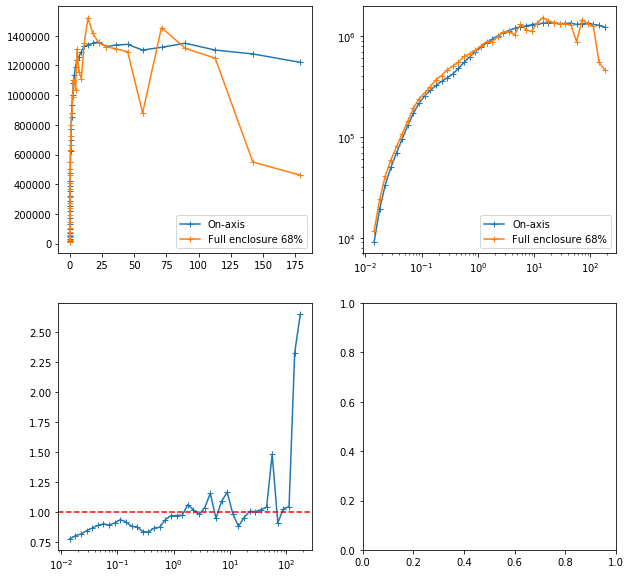

In [51]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(10,10))

ax1.plot(etrue_center,aeff_onaxis,marker="+",label="On-axis")
ax1.plot(etrue_center,aeff68,marker="+",label="Full enclosure 68%")
ax1.legend()

ax2.plot(etrue_center,aeff_onaxis,marker="+",label="On-axis")
ax2.plot(etrue_center,aeff68,marker="+",label="Full enclosure 68%")
ax2.semilogx()
ax2.semilogy()
ax2.legend()
ax3.plot(etrue_center,aeff_onaxis/aeff68,marker="+",label="Ratio")
ax3.semilogx()
ax3.axhline(y=1.,ls="--",color="red")
plt.show()

## Compare background

In [52]:
bkg_data = irfs["bkg"].evaluate_integrate(
    fov_lon=0 * u.deg, fov_lat=offset, energy_reco=energy_reco
)
bkg = bkg_data*solid_angles
bkg = bkg.to(1/u.s)
bkg

<Quantity [0.00000000e+00, 5.41403430e+00, 3.11753949e+00, 1.03811460e+00,
           3.73360833e-01, 1.16130985e-01, 3.97262029e-02, 1.49528662e-02,
           5.56744524e-03, 2.15982491e-03, 9.38992451e-04, 3.84262261e-04,
           1.35694500e-04, 5.35278645e-05, 2.40087131e-05, 9.86376558e-06,
           4.05613143e-06, 2.39056006e-06, 1.77087563e-06, 6.59272755e-07,
           3.67594329e-07] 1 / s>

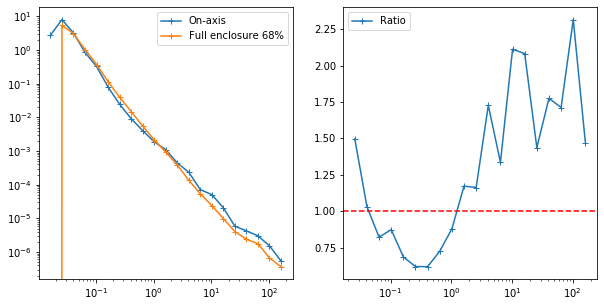

In [53]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(10,5))

ax1.plot(erec_center,bkg_onaxis,marker="+",label="On-axis")
ax1.plot(erec_center,bkg,marker="+",label="Full enclosure 68%")
ax1.semilogx()
ax1.semilogy()
ax1.legend()

ax2.plot(erec_center,bkg_onaxis/bkg,marker="+",label="Ratio")
ax2.semilogx()
ax2.axhline(y=1.,ls="--",color="red")
ax2.legend()
plt.show()